# How to perform 3D tracking using 3 webcams (anipose + deeplabcut pretrained)

<br>
<div align="center">Wim Pouw (wim.pouw@donders.ru.nl)</div>

<img src="Images/envision_banner.png" alt="isolated" width="300"/>

# Info documents
This python coding module shows some basic data wrangling procedures that are often required when analyzing motion, sound, for events bounded by annotations. These procedures include merging data streams, deriving 1-dimensional measures from high dimensional motion tracking data, accounthing for different sampling rates, and smoothing the data. We also show some simple applications once we have a multimodal dataset prepared, in the form of a simple peak analysis.

location Repository: https://github.com/WimPouw/envisionBOX_modulesWP/tree/main/3Dtracking_anipose_dlc

location Jupyter notebook: https://github.com/WimPouw/envisionBOX_modulesWP/tree/main/3Dtracking_anipose_dlc/3Dtracking_anipose_dlc.ipynb

citation for anipose: Karashchuk, P., Rupp, K. L., Dickinson, E. S., Walling-Bell, S., Sanders, E., Azim, E., ... & Tuthill, J. C. (2021). Anipose: a toolkit for robust markerless 3D pose estimation. Cell reports, 36(13).

citation for deeplabcut: Mathis, A., Mamidanna, P., Cury, K. M., Abe, T., Murthy, V. N., Mathis, M. W., & Bethge, M. (2018). DeepLabCut: markerless pose estimation of user-defined body parts with deep learning. Nature neuroscience, 21(9), 1281-1289.

citation for this module: Pouw, W. (2023). How to perform 3D tracking using 3 webcams (anipose + deeplabcut pretrained). [the day you viewed the site]. Retrieved from: https://envisionbox.org/3Dtracking_anipose_dlc.html


# Background

Here there is a example code and data to infer from three webcams capturing 2D data the 3D pose data. We do this first by finding the angles between the cameras using anipose and three synced videos of a charucoboard (see below). Then we run deeplabcut pre-trained human model on each of the three test videos where someone is doing silly movements. Having the deeplabcut output, we use this as input for the second stage of anipose, which is a triangulation of the 2D data to 3D given the information of the calibration of the cameras.

While we largely follow the anipose materials (https://anipose.readthedocs.io/en/latest/aniposelib-tutorial.html) it still took some time to get going due to several reasons (e.g., opencv has been updated and is not compatible with anipose anymore if we use a charucoboard; there is no test data that one can use) and therefore this module provides hopefully a easier way to try it out with your own data.

Make sure you install the requirements.txt for running this module (pip install -r requirements.txt).

## Step 1: Calibration of cameras using a charucoboard

Freemocap, anipose, or pose2sim all calibration file. Here is a script that allows you to calibrate your cameras, producing a toml with camera intrinsics and extrinsics angles that are needed to then further triangulate your 2D tracking.

We use the following charucoboard, which when printed on a A2, gives the below dimensions you need to set for your anipose settings.

<img src="./charucoboard/charuco_board_image.png" alt="isolated" width="400"/>

In [4]:
import os
import glob
import cv2
import aniposelib
from aniposelib.boards import CharucoBoard, Checkerboard
from aniposelib.cameras import Camera, CameraGroup
from aniposelib.utils import load_pose2d_fnames
import tables

# set your folders
calfolder = "./testdata/calibration_videos/"
calresults = "./calibration_results/"

# check for mp4 files
mp4_files = glob.glob(calfolder + '/*.mp4')

#transfer the list of mp4files in a list as anipose will need that
vidnames = []
for file in mp4_files:
    vidnames.append([file])

# set your camera names
cam_names = ['cam1', 'cam2', 'cam3']
cam_regex = 'cam([0-9])'
print(vidnames)

[['./testdata/calibration_videos\\calib60_cam1.mp4'], ['./testdata/calibration_videos\\calib60_cam2.mp4'], ['./testdata/calibration_videos\\calib60_cam3.mp4']]


## Show example

In [3]:
# Example video of the calibration
from IPython.display import Video

Video(vidnames[0][0])

In [6]:
n_cams = len(vidnames)
print("number of cameras = " + str(n_cams))
print("cam names: " + str(cam_names))

# note down the settings for your charucoboard (it depends on what you have printed your charucoboard; here printed on a A2)
board = CharucoBoard(5, 7,
                     square_length=83, # here, in mm but any unit works
                     marker_length=66, # notice that the marks are a little smaller
                     marker_bits=4, dict_size=50) # how many subsquares does the mark have -> 4*4. Dict_size = default

cgroup = CameraGroup.from_names(cam_names, fisheye=False)

number of cameras = 3
cam names: ['cam1', 'cam2', 'cam3']


So next we start the calibration of the cameras. Ideally you want to be left with a low as possible error. But an error around 1 is quite OK. That is what we are getting (~ 1.1 ox error).

In [8]:
# this will take about 15 minutes (mostly due to detection)
# it will detect the charuco board in the videos,
# then calibrate the cameras based on the detections, using iterative bundle adjustment
cgroup.calibrate_videos(vidnames, board)

# if you need to save and load
# example saving and loading for later
cgroup.dump(calresults + 'calibration_anipose.toml')
## example of loading calibration from a file
## you can also load the provided file if you don't want to wait
#cgroup = CameraGroup.load('calibration.toml')

./testdata/calibration_videos\calib60_cam1.mp4


100%|████████████████████████████| 9980/9980 [01:21<00:00, 122.69it/s]


5867 boards detected
./testdata/calibration_videos\calib60_cam2.mp4


100%|████████████████████████████| 9980/9980 [01:36<00:00, 103.95it/s]


7723 boards detected
./testdata/calibration_videos\calib60_cam3.mp4


100%|████████████████████████████| 9980/9980 [01:04<00:00, 155.27it/s]


4493 boards detected
defaultdict(<class 'int'>,
            {('cam1', 'cam2'): 2985,
             ('cam1', 'cam3'): 547,
             ('cam2', 'cam1'): 2985,
             ('cam2', 'cam3'): 3082,
             ('cam3', 'cam1'): 547,
             ('cam3', 'cam2'): 3082})
error:  52.802870961161375
n_samples: 100
{(0, 1): (2105, array([29.50279419, 54.69678038])),
 (0, 2): (2105, array([56.43264724, 79.39815531])),
 (1, 2): (2105, array([34.73451251, 54.1152065 ]))}
error: 52.83, mu: 56.4, ratio: 0.613
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         7.0058e+06                                    5.04e+06    
       1              2         8.8185e+05      6.12e+06       6.93e+04       7.43e+05    
       2              3         5.7876e+04      8.24e+05       3.73e+04       6.40e+04    
       3              5         2.8216e+04      2.97e+04       6.40e+03       5.27e+04    
       4              7         2.0835e+0

# Step 2 is tracking the videos with deeplabcut

Now we have a calibration file. We will use deeplabcut to track the test videos. Here we use the human pre-trained model. But! of course you can train your own model, for example on animal poses, or human infant poses. And then input that. 

Note, if you are using a GPU for deeplabcut it would be good to step over to another kernel with your GPU conda environment.

In [2]:
import os
import glob
import cv2
import deeplabcut

# identify all videos that we want to test
calfolder = "./testdata/test_videos/"

mp4_files = glob.glob(calfolder + '/*.mp4')

vidnames = []

for file in mp4_files:
    vidnames.append(file)
    
print(vidnames)

Loading DLC 2.3.5...
['./testdata/test_videos\\sample60_cam1.mp4', './testdata/test_videos\\sample60_cam2.mp4', './testdata/test_videos\\sample60_cam3.mp4']


In [3]:
deeplabcut.create_pretrained_human_project(project = 'test', experimenter = 'johndoe', videos = vidnames, working_directory=os.path.abspath("./deeplabcut/"),
                                    copy_videos=True, videotype=".mp4", createlabeledvideo=True, analyzevideo=True)

LEGACY FUNCTION will be deprecated.... use  deeplabcut.create_pretrained_project(project, experimenter, videos, model='full_human', ..) in the future!
Project "D:\Research_projects\3D_trackingtools\calibrating_3_cam_anipose\deeplabcut\test-johndoe-2023-09-22" already exists!
Loading.... full_human


D:\Research_projects\3D_trackingtools\calibrating_3_cam_anipose\deeplabcut\test-johndoe-2023-09-22\dlc-models\iteration-0\testSep22-trainset95shuffle1\train\pose_cfg.yaml
Analyzing video...
Using snapshot-103000 for model D:\Research_projects\3D_trackingtools\calibrating_3_cam_anipose\deeplabcut\test-johndoe-2023-09-22\dlc-models\iteration-0\testSep22-trainset95shuffle1


C:\Users\Admin\.conda\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all the videos in the directory...
Starting to analyze %  D:\Research_projects\3D_trackingtools\calibrating_3_cam_anipose\deeplabcut\test-johndoe-2023-09-22\videos\sample60_cam3.mp4
Loading  D:\Research_projects\3D_trackingtools\calibrating_3_cam_anipose\deeplabcut\test-johndoe-2023-09-22\videos\sample60_cam3.mp4
Duration of video [s]:  13.0 , recorded with  60.0 fps!
Overall # of frames:  780  found with (before cropping) frame dimensions:  540 960
Starting to extract posture


100%|████████████████████████████████████████████████████████████████████████████████| 780/780 [00:14<00:00, 53.95it/s]


Saving results in D:\Research_projects\3D_trackingtools\calibrating_3_cam_anipose\deeplabcut\test-johndoe-2023-09-22\videos...
Saving csv poses!
Starting to analyze %  D:\Research_projects\3D_trackingtools\calibrating_3_cam_anipose\deeplabcut\test-johndoe-2023-09-22\videos\sample60_cam1.mp4
Loading  D:\Research_projects\3D_trackingtools\calibrating_3_cam_anipose\deeplabcut\test-johndoe-2023-09-22\videos\sample60_cam1.mp4
Duration of video [s]:  13.0 , recorded with  60.0 fps!
Overall # of frames:  780  found with (before cropping) frame dimensions:  540 960
Starting to extract posture


100%|████████████████████████████████████████████████████████████████████████████████| 780/780 [00:09<00:00, 82.67it/s]


Saving results in D:\Research_projects\3D_trackingtools\calibrating_3_cam_anipose\deeplabcut\test-johndoe-2023-09-22\videos...
Saving csv poses!
Starting to analyze %  D:\Research_projects\3D_trackingtools\calibrating_3_cam_anipose\deeplabcut\test-johndoe-2023-09-22\videos\sample60_cam2.mp4
Loading  D:\Research_projects\3D_trackingtools\calibrating_3_cam_anipose\deeplabcut\test-johndoe-2023-09-22\videos\sample60_cam2.mp4
Duration of video [s]:  13.0 , recorded with  60.0 fps!
Overall # of frames:  780  found with (before cropping) frame dimensions:  540 960
Starting to extract posture


100%|████████████████████████████████████████████████████████████████████████████████| 780/780 [00:09<00:00, 82.79it/s]


Saving results in D:\Research_projects\3D_trackingtools\calibrating_3_cam_anipose\deeplabcut\test-johndoe-2023-09-22\videos...
Saving csv poses!
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
Analyzing all the videos in the directory...
Filtering with median model D:\Research_projects\3D_trackingtools\calibrating_3_cam_anipose\deeplabcut\test-johndoe-2023-09-22\videos\sample60_cam2.mp4
Saving filtered csv poses!
Filtering with median model D:\Research_projects\3D_trackingtools\calibrating_3_cam_anipose\deeplabcut\test-johndoe-2023-09-22\videos\sample60_cam3.mp4
Saving filtered csv poses!
Filtering with median model D:\Research_projects\3D_trackingtools\calibrating_3_cam_anipose\deeplabcut\test-johndoe-2023-09-22\videos\sample60_c

100%|███████████████████████████████████████████████████████████████████████████████| 780/780 [00:03<00:00, 221.56it/s]


Starting to process video: D:\Research_projects\3D_trackingtools\calibrating_3_cam_anipose\deeplabcut\test-johndoe-2023-09-22\videos\sample60_cam1.mp4
Loading D:\Research_projects\3D_trackingtools\calibrating_3_cam_anipose\deeplabcut\test-johndoe-2023-09-22\videos\sample60_cam1.mp4 and data.
Duration of video [s]: 13.0, recorded with 60.0 fps!
Overall # of frames: 780 with cropped frame dimensions: 540 960
Generating frames and creating video.


100%|███████████████████████████████████████████████████████████████████████████████| 780/780 [00:03<00:00, 223.16it/s]


Starting to process video: D:\Research_projects\3D_trackingtools\calibrating_3_cam_anipose\deeplabcut\test-johndoe-2023-09-22\videos\sample60_cam3.mp4
Loading D:\Research_projects\3D_trackingtools\calibrating_3_cam_anipose\deeplabcut\test-johndoe-2023-09-22\videos\sample60_cam3.mp4 and data.
Duration of video [s]: 13.0, recorded with 60.0 fps!
Overall # of frames: 780 with cropped frame dimensions: 540 960
Generating frames and creating video.


100%|███████████████████████████████████████████████████████████████████████████████| 780/780 [00:03<00:00, 217.38it/s]


Analyzing all the videos in the directory...
Loading  D:\Research_projects\3D_trackingtools\calibrating_3_cam_anipose\deeplabcut\test-johndoe-2023-09-22\videos\sample60_cam3.mp4 and data.
Loading  D:\Research_projects\3D_trackingtools\calibrating_3_cam_anipose\deeplabcut\test-johndoe-2023-09-22\videos\sample60_cam1.mp4 and data.
Loading  D:\Research_projects\3D_trackingtools\calibrating_3_cam_anipose\deeplabcut\test-johndoe-2023-09-22\videos\sample60_cam2.mp4 and data.
Plots created! Please check the directory "plot-poses" within the video directory


## Results of the tracking

Below we show the output side by side.

In [22]:
# Show output for deeplabcut videos side by side in one video, making one tracking video
import glob
from moviepy.editor import VideoFileClip, clips_array
from IPython.display import Video


calfolder = "./calibration_results/"
project = glob.glob('./deeplabcut/*')
vids = glob.glob(project[0]+"/videos/*_labeled.mp4")

# Load the video clips
video_clips = [VideoFileClip(vid) for vid in vids]

# Concatenate the video clips horizontally
final_video = clips_array([video_clips])

output_path = "./temp/concatenated_video.mp4"
final_video.write_videofile(output_path, codec='libx264')

Video(output_path)

Moviepy - Building video ./temp/concatenated_video.mp4.
Moviepy - Writing video ./temp/concatenated_video.mp4



Moviepy - Done !
Moviepy - video ready ./temp/concatenated_video.mp4


# Step 3 triangulating with anipose

Now that we have tracked the 2D videos with the pretrained full human model from deeplabcut, and we have the camera angles, we can estimate the 3D coordinates of the keypoints using anipose.

In [24]:
# lets identify the output from deeplabcut (gives it in h5)
import glob
calfolder = "./calibration_results/"
project = glob.glob('./deeplabcut/*')
h5s = glob.glob(project[0]+"/videos/*_filtered.h5")
h5files = []

for file in h5s:
    h5files.append(file)
    
print(h5files)

['./deeplabcut\\test-johndoe-2023-09-22/videos\\sample60_cam1DLC_resnet101_testSep22shuffle1_103000_filtered.h5', './deeplabcut\\test-johndoe-2023-09-22/videos\\sample60_cam2DLC_resnet101_testSep22shuffle1_103000_filtered.h5', './deeplabcut\\test-johndoe-2023-09-22/videos\\sample60_cam3DLC_resnet101_testSep22shuffle1_103000_filtered.h5']


In [4]:
import numpy as np
from aniposelib.boards import CharucoBoard, Checkerboard
from aniposelib.cameras import Camera, CameraGroup
from aniposelib.utils import load_pose2d_fnames

#load in calibration
cgroup = CameraGroup.load(calfolder + 'calibration_anipose.toml')

## example triangulation without filtering, should take < 15 seconds
fname_dict = {
    'cam1': h5files[0],
    'cam2': h5files[1],
    'cam3': h5files[2],
}

d = load_pose2d_fnames(fname_dict, cam_names=cgroup.get_names())

score_threshold = 0.5

n_cams, n_points, n_joints, _ = d['points'].shape
points = d['points']
scores = d['scores']

bodyparts = d['bodyparts']

# remove points that are below threshold
points[scores < score_threshold] = np.nan

points_flat = points.reshape(n_cams, -1, 2)
scores_flat = scores.reshape(n_cams, -1)

p3ds_flat = cgroup.triangulate(points_flat, progress=True)
reprojerr_flat = cgroup.reprojection_error(p3ds_flat, points_flat, mean=True)

p3ds = p3ds_flat.reshape(n_points, n_joints, 3)
reprojerr = reprojerr_flat.reshape(n_points, n_joints)

100%|█████████████████████████| 10920/10920 [00:02<00:00, 4025.81it/s]


# Plot the 3D inferred time series for a particular keypoint

With some further data wrangling. You can save the data in a time series objects. You should also smooth your data further. See envisionBox modules for example code on this too.

keypoint 0 = ankle1
keypoint 1 = knee1
keypoint 2 = hip1
keypoint 3 = hip2
keypoint 4 = knee2
keypoint 5 = ankle2
keypoint 6 = wrist1
keypoint 7 = elbow1
keypoint 8 = shoulder1
keypoint 9 = shoulder2
keypoint 10 = elbow2
keypoint 11 = wrist2
keypoint 12 = chin
keypoint 13 = forehead


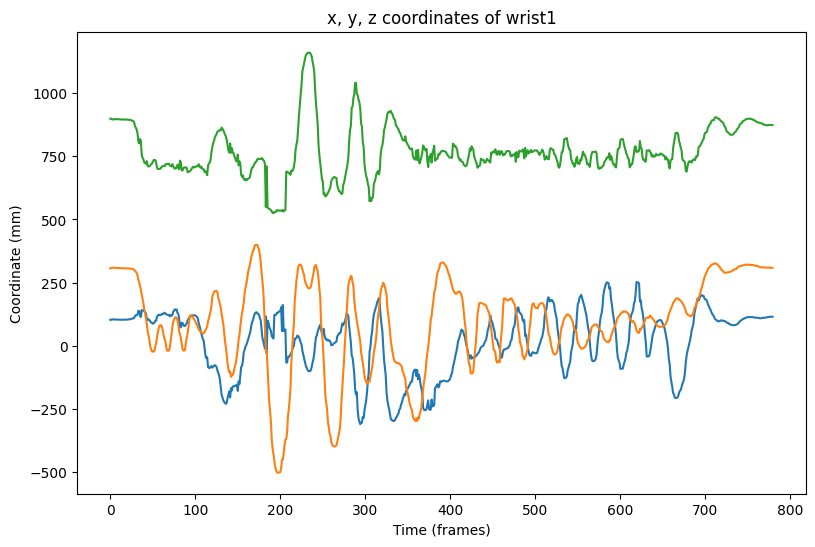

In [25]:
# plot the x, y, z coordinates of joint 0
import matplotlib.pyplot as plt

#plot a keypoints
plt.figure(figsize=(9.4, 6))
plt.plot(p3ds[:, 6, 0]) #x
plt.plot(p3ds[:, 6, 1]) #y
plt.plot(p3ds[:, 6, 2]) #z
plt.xlabel("Time (frames)")
plt.ylabel("Coordinate (mm)")
plt.title("x, y, z coordinates of {}".format(bodyparts[6]))

for i, bodypart in enumerate(bodyparts):
    print('keypoint ' + str(i) + ' = ' + bodypart)